## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [1]:
import os
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import f1_score
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

### 資料前處理

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

### 建構模型

In [5]:
def build_mlp(input_data_shape, dropout_rate, l2_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), input_shape=input_data_shape, padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層3與池化層3
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層4
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層5
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(l2_rate)))

    return model

### 超參數

In [6]:
## 超參數設定
# OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
OPTIMIZER = ["adam", "rmsprop"]
LEARNING_RATE = 1e-3
L2_EXP = 1e-4
DROPOUT = [0.1, 0.2]
EPOCHS = 100
BATCH_SIZE = 32
MOMENTUM = 0.95

### Callback functions

In [7]:
# 載入 Callbacks
earlystop = EarlyStopping(monitor="val_loss", 
                          patience=50, 
                          verbose=1
                          )

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

### 自定義損失函數

In [8]:
import tensorflow as tf
import keras.backend as K

#ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

def combined_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return 0.3 * tf.reduce_mean(reduced_fl) + 0.7 * keras.losses.categorical_crossentropy(y_true, y_pred)
    return focal_loss_fixed


### 訓練模型

In [9]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, drop_rate in enumerate(DROPOUT):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, ls=%.6f, dr=%.2f, bs=%d" % (optr, LEARNING_RATE, drop_rate, BATCH_SIZE))
        
        # create model
        model = build_mlp(x_train.shape[1:], drop_rate, L2_EXP)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        #model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.compile(loss=combined_loss(),
                      metrics=["accuracy"],
                      optimizer=optimizer)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True, 
                  callbacks=[earlystop, model_ckpt, reduce_lr, log_f1sc])

        # Collect results
        exp_tag = "%s:%s" % (("exp_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=adam, ls=0.001000, dr=0.10, bs=32
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 288s 6ms/step - loss: 2.1268 - acc: 0.5025 - val_loss: 2.2454 - val_acc: 0.4934
Epoch 2/100
   32/50000 [..............................] - ETA: 4:41 - loss: 1.4273 - acc: 0.5625

c:\users\kevin\anaconda3\envs\tf_kevin\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 284s 6ms/step - loss: 1.3993 - acc: 0.6702 - val_loss: 1.6223 - val_acc: 0.6257
Epoch 3/100
50000/50000 [==============================] - 284s 6ms/step - loss: 1.1033 - acc: 0.7371 - val_loss: 1.4581 - val_acc: 0.6775
Epoch 4/100
50000/50000 [==============================] - 284s 6ms/step - loss: 0.9292 - acc: 0.7753 - val_loss: 1.0721 - val_acc: 0.7641
Epoch 5/100
50000/50000 [==============================] - 284s 6ms/step - loss: 0.7793 - acc: 0.8117 - val_loss: 1.0798 - val_acc: 0.7633
Epoch 6/100
50000/50000 [==============================] - 284s 6ms/step - loss: 0.6738 - acc: 0.8346 - val_loss: 1.1792 - val_acc: 0.7508
Epoch 7/100
50000/50000 [==============================] - 284s 6ms/step - loss: 0.5802 - acc: 0.8559 - val_loss: 1.3065 - val_acc: 0.7464
Epoch 8/100
50000/50000 [==============================] - 284s 6ms/step - loss: 0.4922 - acc: 0.8749 - val_loss: 1.5450 - val_acc: 0.7284
Epoch 9/100
50000/50000 [==============

Epoch 00054: early stopping
Experiment with Optimizer=rmsprop, ls=0.001000, dr=0.10, bs=32
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 281s 6ms/step - loss: 2.0669 - acc: 0.5139 - val_loss: 1.8356 - val_acc: 0.5669
Epoch 2/100
50000/50000 [==============================] - 279s 6ms/step - loss: 1.3666 - acc: 0.6815 - val_loss: 2.8103 - val_acc: 0.5243
Epoch 3/100
50000/50000 [==============================] - 279s 6ms/step - loss: 1.1253 - acc: 0.7395 - val_loss: 1.4389 - val_acc: 0.6901
Epoch 4/100
50000/50000 [==============================] - 279s 6ms/step - loss: 0.9695 - acc: 0.7797 - val_loss: 1.4851 - val_acc: 0.6991
Epoch 5/100
50000/50000 [==============================] - 279s 6ms/step - loss: 0.8495 - acc: 0.8085 - val_loss: 1.1784 - val_acc: 0.7617
Epoch 6/100
50000/50000 [==============================] - 279s 6ms/step - loss: 0.7410 - acc: 0.8361 - val_loss: 1.8824 - val_acc: 0.6604
Epoch 7/100
50000/50000 [

50000/50000 [==============================] - 280s 6ms/step - loss: 0.0417 - acc: 0.9972 - val_loss: 1.6032 - val_acc: 0.8401
Epoch 54/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.0417 - acc: 0.9976 - val_loss: 1.6084 - val_acc: 0.8389
Epoch 55/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.0412 - acc: 0.9973 - val_loss: 1.6095 - val_acc: 0.8399

Epoch 00055: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00055: early stopping
Experiment with Optimizer=adam, ls=0.001000, dr=0.20, bs=32
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 286s 6ms/step - loss: 2.2570 - acc: 0.4718 - val_loss: 2.7139 - val_acc: 0.4118
Epoch 2/100
50000/50000 [==============================] - 285s 6ms/step - loss: 1.5637 - acc: 0.6340 - val_loss: 2.8223 - val_acc: 0.4422
Epoch 3/100
50000/50000 [==============================] - 285s 6ms/step - loss: 1.2514 - acc: 0

50000/50000 [==============================] - 285s 6ms/step - loss: 0.0479 - acc: 0.9919 - val_loss: 1.4808 - val_acc: 0.8364

Epoch 00051: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 52/100
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0492 - acc: 0.9911 - val_loss: 1.4637 - val_acc: 0.8370
Epoch 53/100
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0499 - acc: 0.9908 - val_loss: 1.4663 - val_acc: 0.8371
Epoch 54/100
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0478 - acc: 0.9918 - val_loss: 1.4702 - val_acc: 0.8378
Epoch 55/100
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0479 - acc: 0.9913 - val_loss: 1.4668 - val_acc: 0.8383
Epoch 56/100
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0447 - acc: 0.9925 - val_loss: 1.4679 - val_acc: 0.8374

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 57/1

50000/50000 [==============================] - 280s 6ms/step - loss: 0.1015 - acc: 0.9897 - val_loss: 1.6504 - val_acc: 0.8382
Epoch 43/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1065 - acc: 0.9893 - val_loss: 1.6725 - val_acc: 0.8377

Epoch 00043: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 44/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1028 - acc: 0.9894 - val_loss: 1.6540 - val_acc: 0.8371
Epoch 45/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1038 - acc: 0.9894 - val_loss: 1.6580 - val_acc: 0.8373
Epoch 46/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1002 - acc: 0.9904 - val_loss: 1.6487 - val_acc: 0.8385
Epoch 47/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1007 - acc: 0.9899 - val_loss: 1.6573 - val_acc: 0.8391
Epoch 48/100
50000/50000 [==============================] - 280s 6ms/step - loss: 0.1000 - a

## Plot loss history

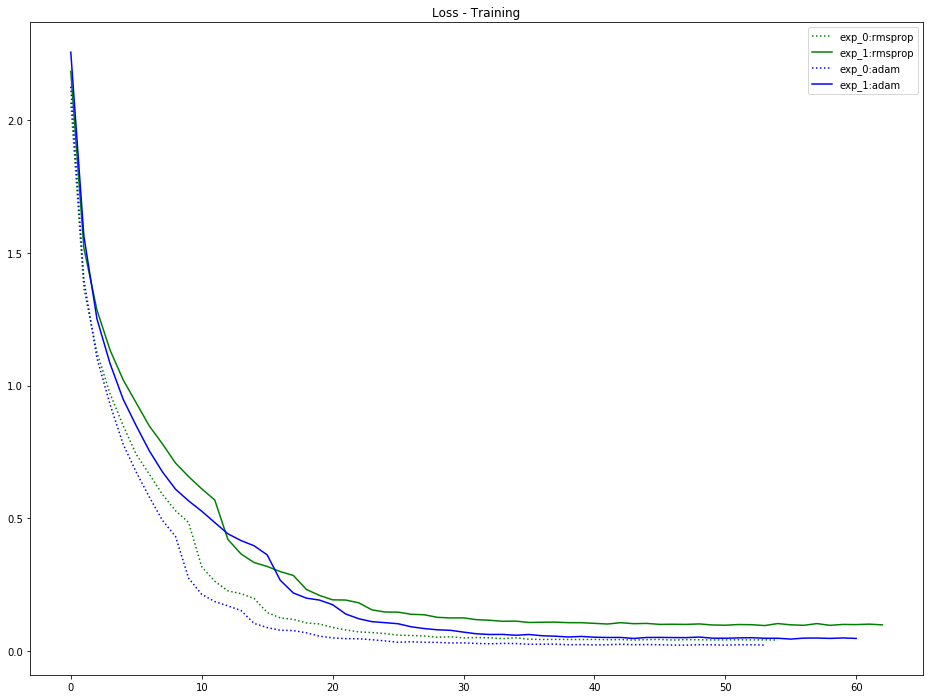

In [10]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_loss["exp_0:sgd"][0])), tra_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_1:sgd"][0])), tra_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_2:sgd"][0])), tra_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_3:sgd"][0])), tra_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_4:sgd"][0])), tra_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(tra_loss["exp_0:rmsprop"][0])), tra_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(tra_loss["exp_1:rmsprop"][0])), tra_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_2:rmsprop"][0])), tra_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_3:rmsprop"][0])), tra_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_4:rmsprop"][0])), tra_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_loss["exp_0:adam"][0])), tra_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_loss["exp_1:adam"][0])), tra_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(tra_loss["exp_2:adam"][0])), tra_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_loss["exp_3:adam"][0])), tra_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_loss["exp_4:adam"][0])), tra_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_loss["exp_0:adagrad"][0])), tra_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_1:adagrad"][0])), tra_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_2:adagrad"][0])), tra_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_3:adagrad"][0])), tra_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_4:adagrad"][0])), tra_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

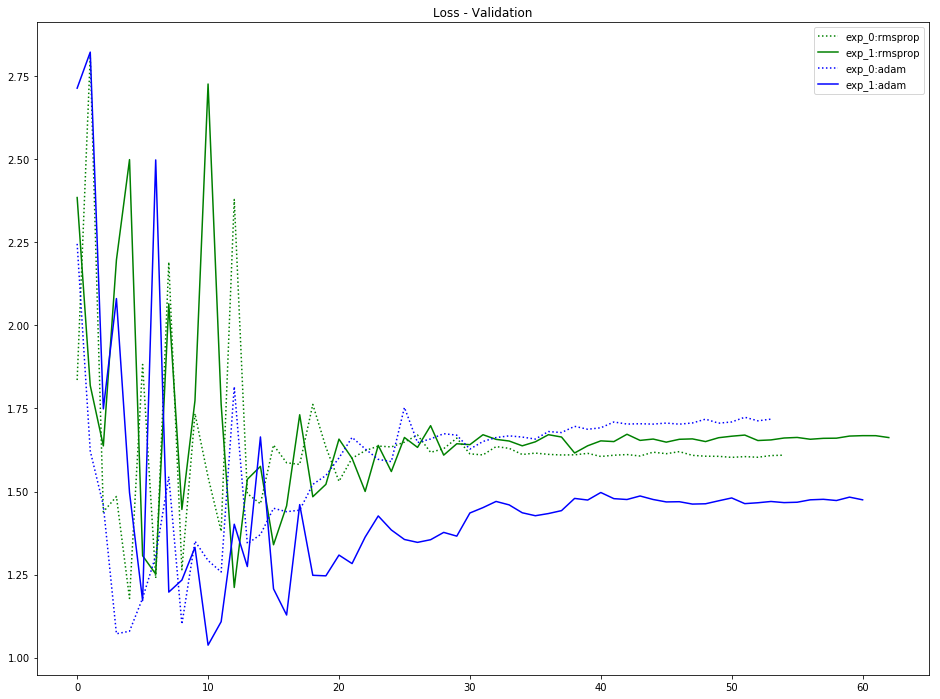

In [11]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_loss["exp_0:sgd"][0])), val_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_loss["exp_1:sgd"][0])), val_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_loss["exp_2:sgd"][0])), val_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_loss["exp_3:sgd"][0])), val_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_loss["exp_4:sgd"][0])), val_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(val_loss["exp_0:rmsprop"][0])), val_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(val_loss["exp_1:rmsprop"][0])), val_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_2:rmsprop"][0])), val_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_3:rmsprop"][0])), val_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_4:rmsprop"][0])), val_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_loss["exp_0:adam"][0])), val_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_loss["exp_1:adam"][0])), val_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(val_loss["exp_2:adam"][0])), val_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_loss["exp_3:adam"][0])), val_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_loss["exp_4:adam"][0])), val_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_loss["exp_0:adagrad"][0])), val_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_1:adagrad"][0])), val_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_2:adagrad"][0])), val_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_3:adagrad"][0])), val_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_4:adagrad"][0])), val_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.2, 4.882812731921149e-07 有較低的loss

## Plot accu history

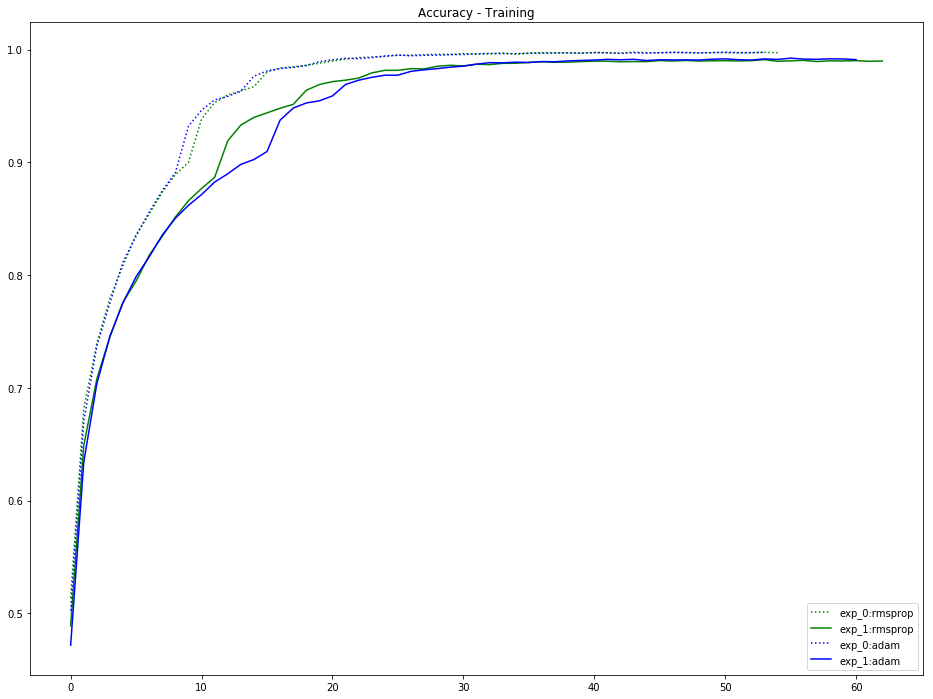

In [12]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_accu["exp_0:sgd"][0])), tra_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_1:sgd"][0])), tra_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_2:sgd"][0])), tra_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_3:sgd"][0])), tra_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_4:sgd"][0])), tra_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(tra_accu["exp_0:rmsprop"][0])), tra_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(tra_accu["exp_1:rmsprop"][0])), tra_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_2:rmsprop"][0])), tra_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_3:rmsprop"][0])), tra_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_4:rmsprop"][0])), tra_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_accu["exp_0:adam"][0])), tra_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_accu["exp_1:adam"][0])), tra_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(tra_accu["exp_2:adam"][0])), tra_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_accu["exp_3:adam"][0])), tra_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_accu["exp_4:adam"][0])), tra_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_accu["exp_0:adagrad"][0])), tra_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_1:adagrad"][0])), tra_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_2:adagrad"][0])), tra_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_3:adagrad"][0])), tra_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_4:adagrad"][0])), tra_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

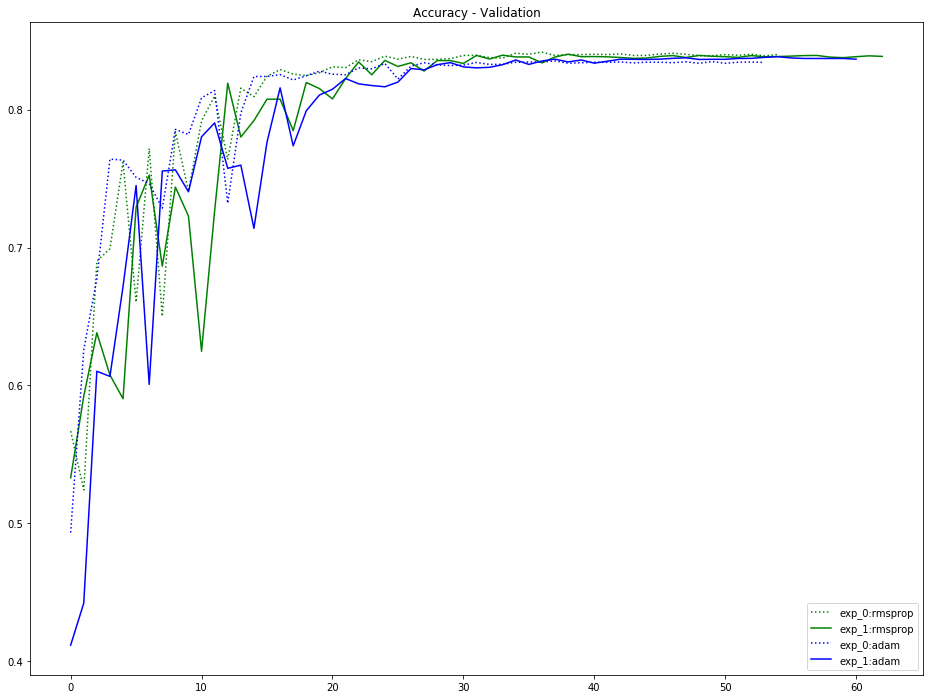

In [13]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_accu["exp_0:sgd"][0])), val_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_accu["exp_1:sgd"][0])), val_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_accu["exp_2:sgd"][0])), val_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_accu["exp_3:sgd"][0])), val_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_accu["exp_4:sgd"][0])), val_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(val_accu["exp_0:rmsprop"][0])), val_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(val_accu["exp_1:rmsprop"][0])), val_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_2:rmsprop"][0])), val_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_3:rmsprop"][0])), val_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_4:rmsprop"][0])), val_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_accu["exp_0:adam"][0])), val_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_accu["exp_1:adam"][0])), val_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(val_accu["exp_2:adam"][0])), val_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_accu["exp_3:adam"][0])), val_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_accu["exp_4:adam"][0])), val_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_accu["exp_0:adagrad"][0])), val_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_1:adagrad"][0])), val_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_2:adagrad"][0])), val_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_3:adagrad"][0])), val_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_4:adagrad"][0])), val_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.1, learning rate=9.765625463842298e-07.有較好的準確率

## Load back

In [14]:
# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

ValueError: Unknown loss function:focal_loss_fixed

In [ ]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white